## Setup

#### Load the libaries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from collections import Counter
import scipy.stats as stats

#### Load the Constants

In [2]:
MODEL = 'gpt-4' # 'gpt-3.5-turbo'
TEMPERATURE = 0.0
TEMPERATURE = str(TEMPERATURE).replace('.', '_')
N_REPETITIONS = 0
LANGUAGES = ['english', 'portuguese']

In [3]:
if N_REPETITIONS <= 0 or (N_REPETITIONS != int(N_REPETITIONS)):
    print(f'N_REPETITIONS should be a positive integer, not {N_REPETITIONS}')
    print('N_REPETITIONS will be set to 1')
    N_REPETITIONS = 1

N_REPETITIONS should be a positive integer, not 0
N_REPETITIONS will be set to 1


### Read the csv file with the responses

In [4]:
if N_REPETITIONS > 1:
    df = pd.read_csv(f"responses/{MODEL}_Temperature{TEMPERATURE}_repetitions{N_REPETITIONS}.csv")
else:
    df = pd.read_csv(f"responses/{MODEL}_Temperature{TEMPERATURE}.csv")

### Data Cleaning

In [5]:
def get_response(response):
    options = {'a)': 'a', 'b)':'b', 'c)': 'c', 'd)':'d'}
    
    for option in options.keys():
        if option in response:
            return options[option]
    else:
        return response

In [6]:
df['answer'] = df['answer'].str.lower()

for language in LANGUAGES:
    if N_REPETITIONS <= 1:
        df[f'responses_{language}'] = df[f'responses_{language}'].str.lower()
        df[f'responses_{language}'] = df[f'responses_{language}'].apply(get_response)
    else:
        for n in range(N_REPETITIONS):
            df[f'responses_{language}_{n}'] = df[f'responses_{language}_{n}'].str.lower()
            df[f'responses_{language}_{n}'] = df[f'responses_{language}_{n}'].apply(get_response)

In [7]:
# Function to calculate the most common value and confidence interval for a row
def calculate_most_common_and_ci(row):
    # Count the occurrences of each value
    value_counts = Counter(row)

    # Calculate the mode
    mode = value_counts.most_common(1)[0][0]

    # Calculate the expected frequency of the mode under the null hypothesis
    total_items = len(row)
    expected_frequency = total_items / 4  # Assuming equal probability for each value

    # Perform a chi-squared test to calculate the p-value
    observed_frequency = value_counts[mode]
    chi_squared_statistic = ((observed_frequency - expected_frequency) ** 2) / expected_frequency
    degrees_of_freedom = 4 - 1  # There are 4 possible values, so 4 - 1 degrees of freedom
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, degrees_of_freedom)

    ratio = observed_frequency / total_items

    return mode, p_value, ratio

In [8]:
if N_REPETITIONS > 1:
    for language in LANGUAGES:
        print(language)
        cols = [f'responses_{language}_{n}' for n in range(N_REPETITIONS)]
        print(cols)
        # Calculate the most common value and confidence interval for each row
        df['responses_{language}'], df['P-value_{language}'], df['ratio_{language}'] = zip(*df[cols].apply(calculate_most_common_and_ci, axis=1))


### Data Analysis

In [9]:
# Calculate the matches between 'answer' and 'responses'
for language in LANGUAGES:
    df[f'match_{language}'] = df['answer'] == df[f'responses_{language}']

df['Total'] = True

# Group by 'test', 'year', and 'theme' and calculate the count of matches
aggregations = {f'match_{language}': 'sum' for language in LANGUAGES}
aggregations['Total'] = 'sum'

matches_by_test = df.groupby(['test', 'year', 'theme']).agg(aggregations).reset_index()

In [10]:
# Create folder to save the plots and the csv file if it does not exist
if not os.path.exists(f'results_{MODEL}_Temperature{TEMPERATURE}'):
    os.makedirs(f'results_{MODEL}_Temperature{TEMPERATURE}')

matches_by_test.to_csv(f'results_{MODEL}_Temperature{TEMPERATURE}/matches_results_{MODEL}.csv', index=False)

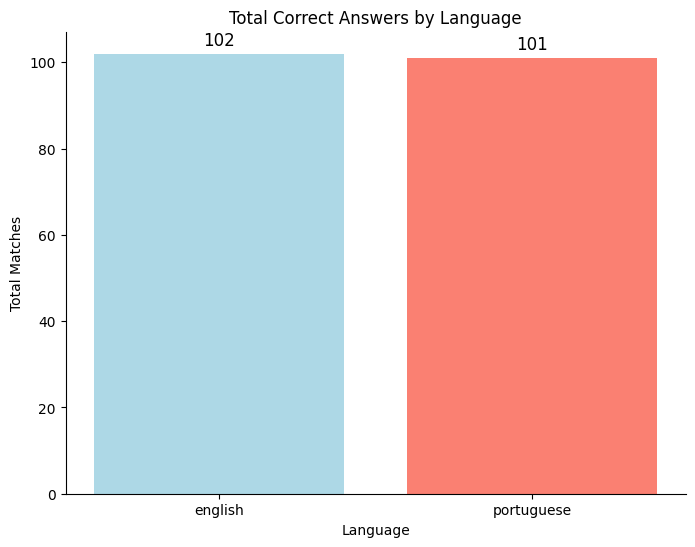

In [20]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the total matches
totals = [df[f'match_{language}'].sum() for language in LANGUAGES]
colors = ['lightblue', 'salmon', 'seagreen', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors[:len(LANGUAGES)]
bars = ax.bar(LANGUAGES, totals, color=colors)

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.xlabel('Language')
plt.ylabel('Total Matches')
plt.title('Total Correct Answers by Language')

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/total_matches_{MODEL}.png', bbox_inches='tight')
plt.show()

In [12]:
matches_by_test_group = matches_by_test.groupby('theme').agg(aggregations).reset_index()

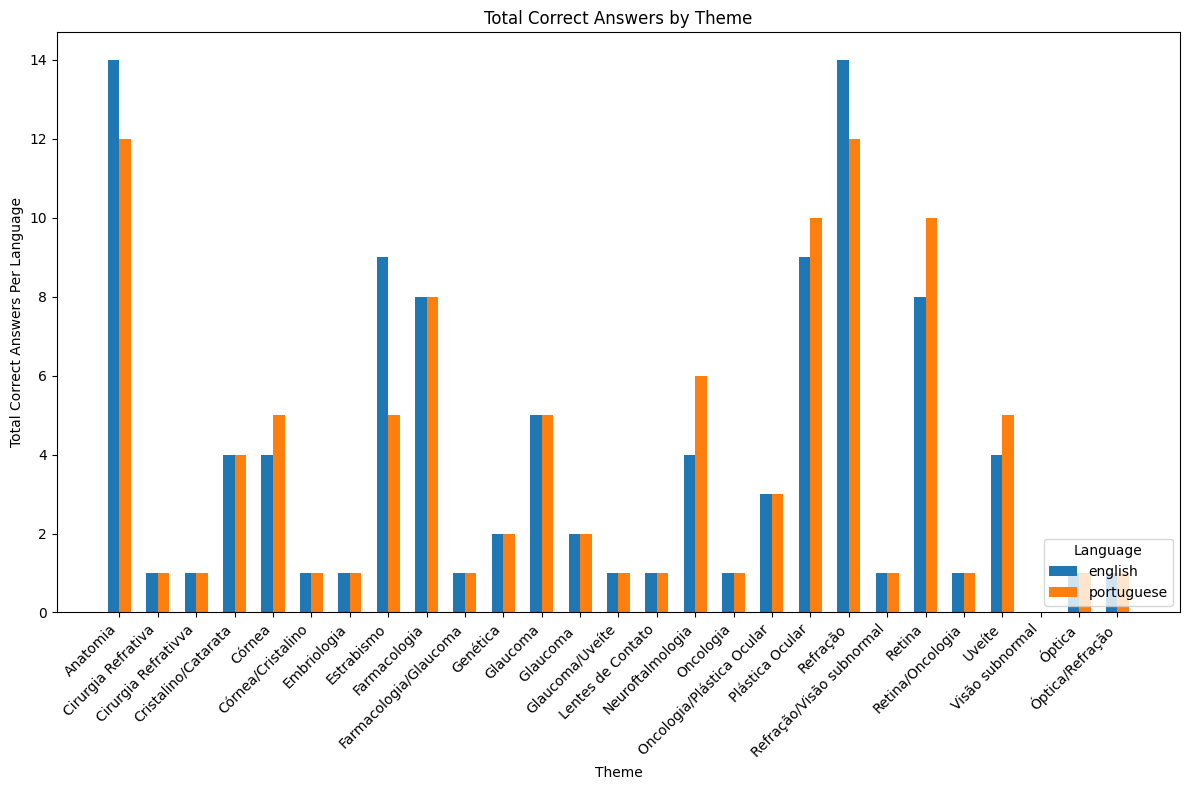

In [13]:
# Compare English and Portuguese matches by theme
fig, ax = plt.subplots(figsize=(12, 8))

# Set the bar width
bar_width = 0.3

# Calculate the positions for the bars
bar_positions = range(len(matches_by_test_group['theme']))
bar_positions_language = [p + i * bar_width for p in bar_positions for i, _ in enumerate(LANGUAGES)]


# Plot the matches per language
for i, language in enumerate(LANGUAGES):
    #ax.bar(bar_positions, matches_by_test_group[F'match_{language}'], width=bar_width, label=language)
    ax.bar(
        [p + i * bar_width for p in bar_positions],
        matches_by_test_group[f'match_{language}'],
        width=bar_width,
        label=language
    )

# Customize the plot
ax.set_xlabel('Theme')
ax.set_ylabel('Total Correct Answers Per Language')
ax.set_title('Total Correct Answers by Theme')
ax.set_xticks([p + (bar_width * (len(LANGUAGES) - 1) / 2) for p in bar_positions])
ax.set_xticklabels(matches_by_test_group['theme'], rotation=45, ha='right')

# Add a legend
plt.legend(title='Language', loc='lower right')

plt.tight_layout()

plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/matches_by_theme_{MODEL}.png', bbox_inches='tight')
plt.show()


      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Anatomia             14                12     21                 66.666667   

   portuguese_ratio_percentage  
0                    57.142857  


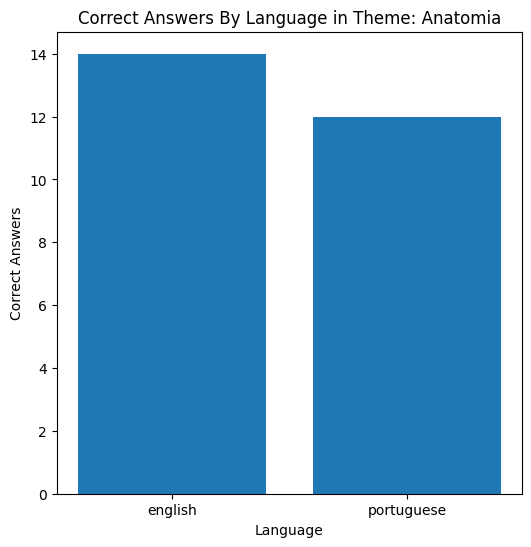

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Córnea              4                 5     10                      40.0   

   portuguese_ratio_percentage  
0                         50.0  


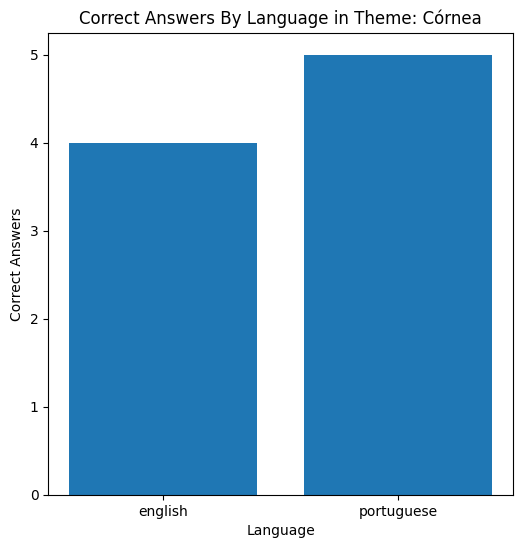

         theme  match_english  match_portuguese  Total  \
0  Embriologia              1                 1      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


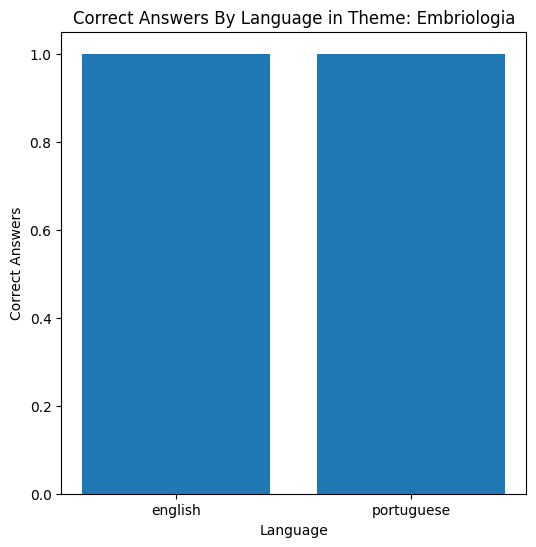

          theme  match_english  match_portuguese  Total  \
0  Farmacologia              8                 8      9   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 88.888889                    88.888889  


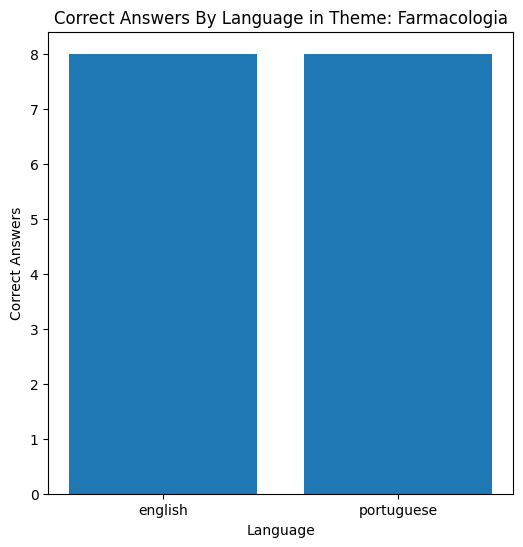

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Genética              2                 2      2                     100.0   

   portuguese_ratio_percentage  
0                        100.0  


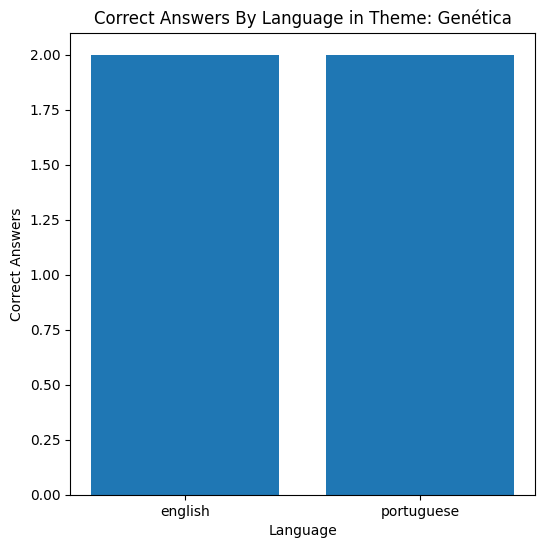

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Glaucoma              5                 5      7                 71.428571   

   portuguese_ratio_percentage  
0                    71.428571  


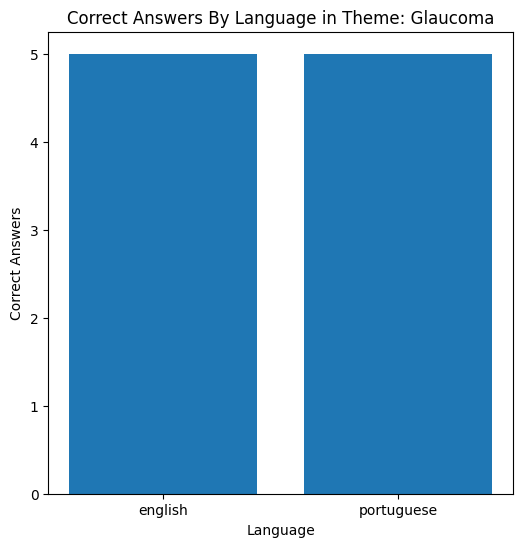

       theme  match_english  match_portuguese  Total  \
0  Oncologia              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


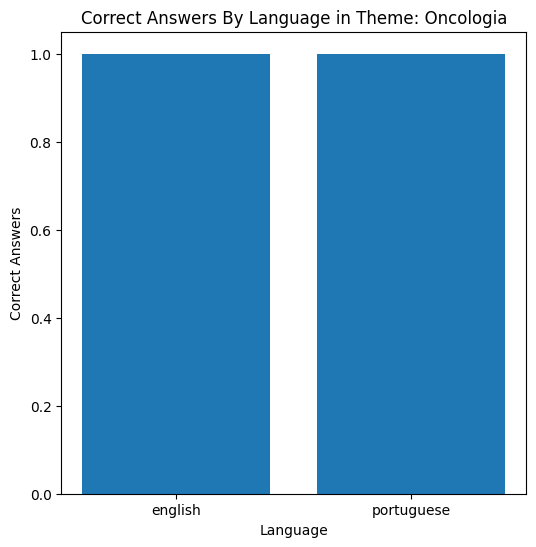

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Refração             14                12     31                  45.16129   

   portuguese_ratio_percentage  
0                    38.709677  


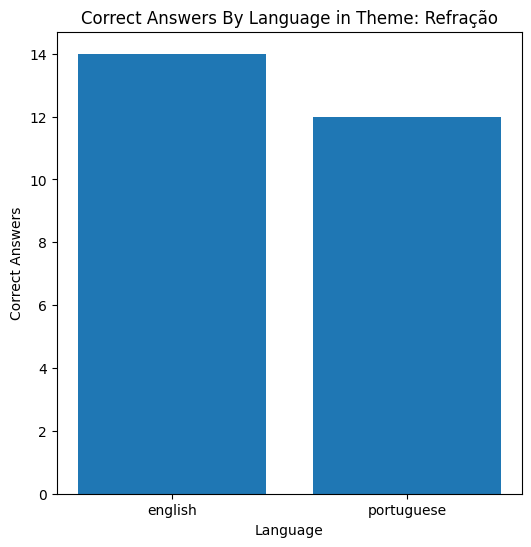

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Retina              8                10     12                 66.666667   

   portuguese_ratio_percentage  
0                    83.333333  


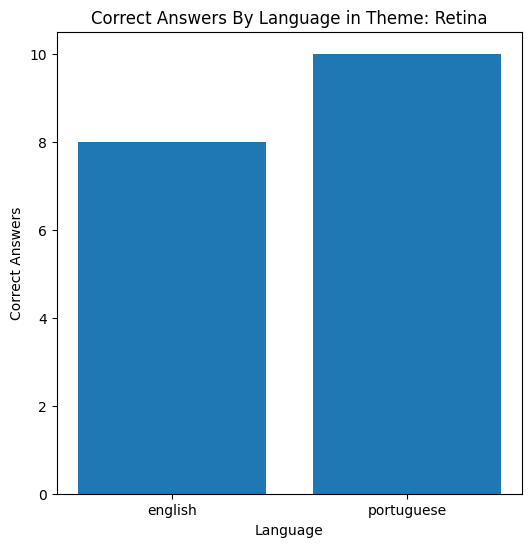

                theme  match_english  match_portuguese  Total  \
0  Cirurgia Refrativa              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


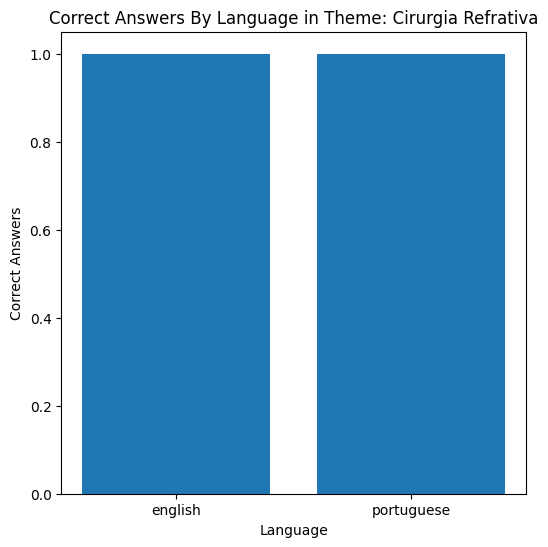

                 theme  match_english  match_portuguese  Total  \
0  Cirurgia Refrativva              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


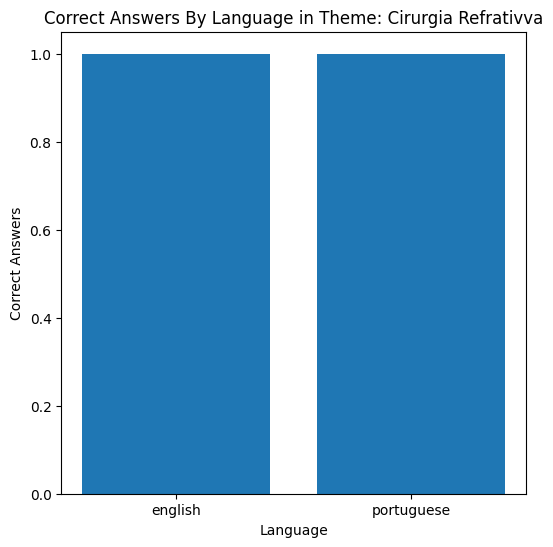

                 theme  match_english  match_portuguese  Total  \
0  Cristalino/Catarata              4                 4      8   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


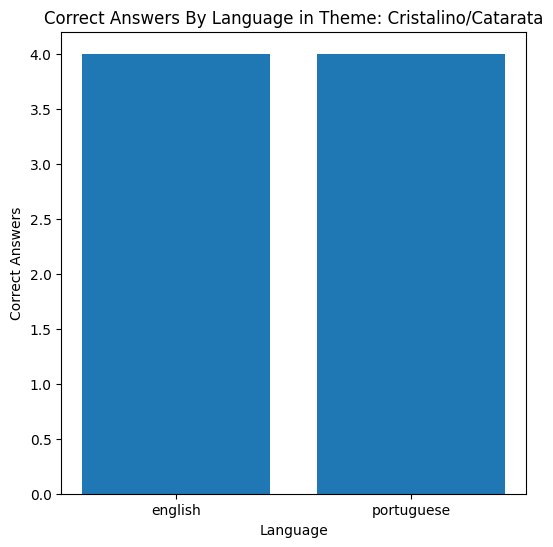

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Córnea              4                 5     10                      40.0   

   portuguese_ratio_percentage  
0                         50.0  


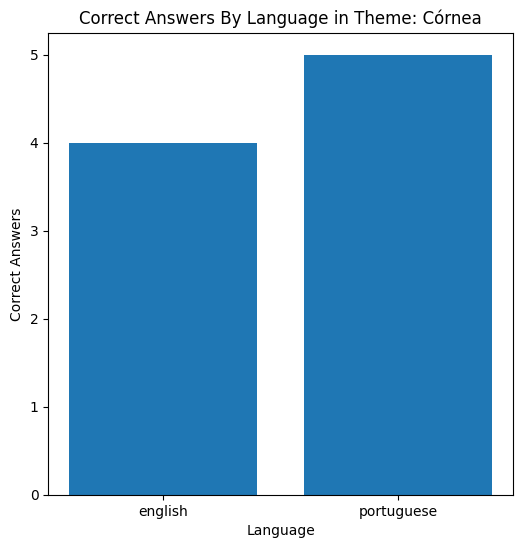

               theme  match_english  match_portuguese  Total  \
0  Córnea/Cristalino              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


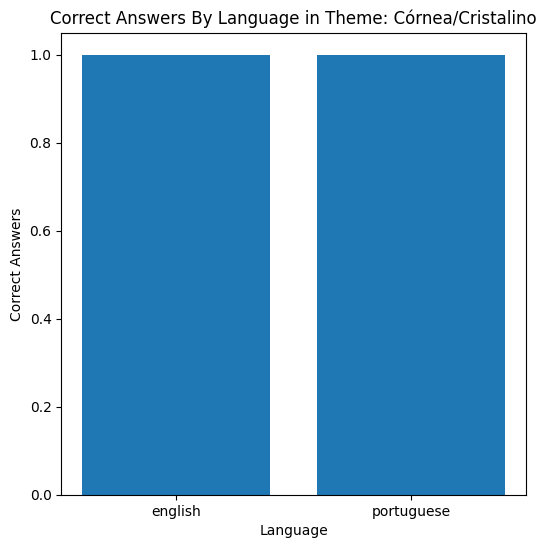

        theme  match_english  match_portuguese  Total  \
0  Estrabismo              9                 5     11   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 81.818182                    45.454545  


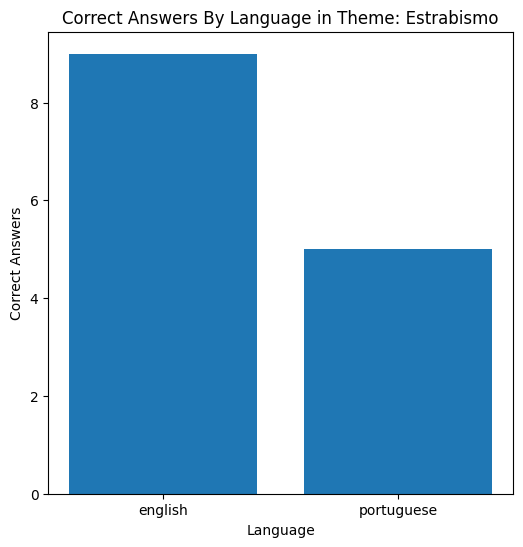

          theme  match_english  match_portuguese  Total  \
0  Farmacologia              8                 8      9   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 88.888889                    88.888889  


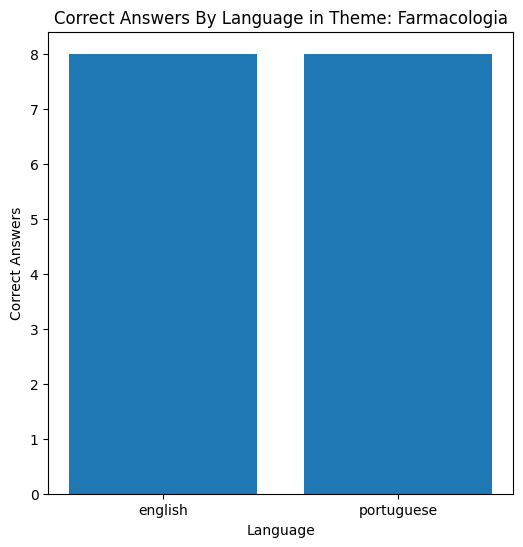

                   theme  match_english  match_portuguese  Total  \
0  Farmacologia/Glaucoma              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


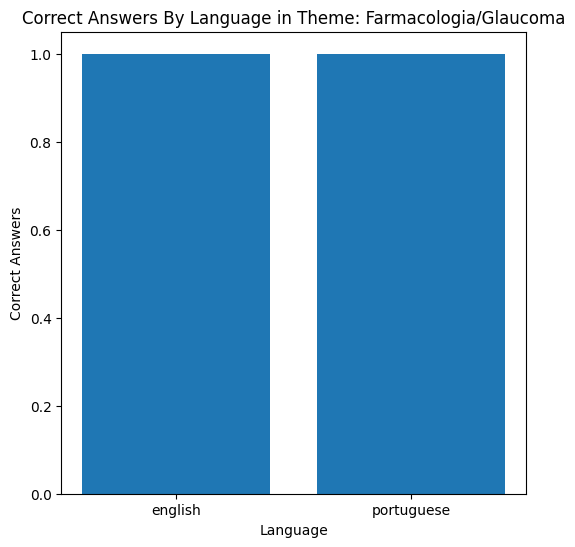

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Glaucoma              5                 5      7                 71.428571   

   portuguese_ratio_percentage  
0                    71.428571  


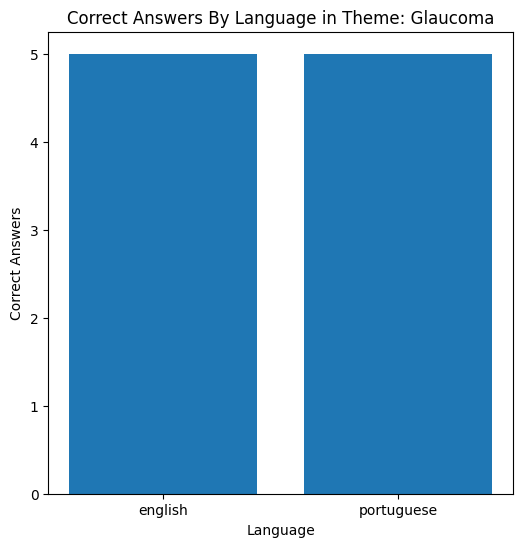

       theme  match_english  match_portuguese  Total  \
0  Glaucoma               2                 2      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


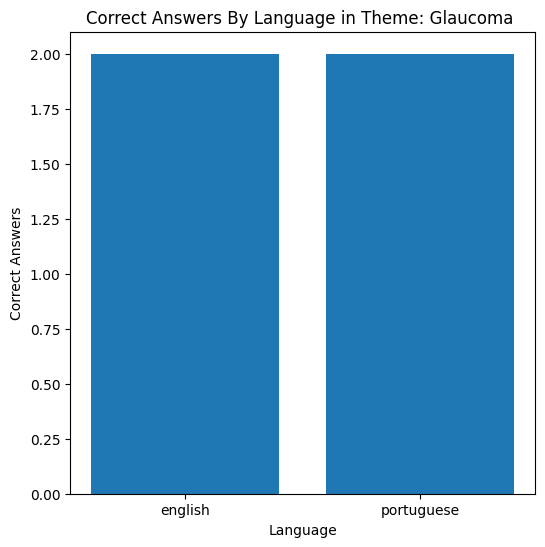

             theme  match_english  match_portuguese  Total  \
0  Glaucoma/Uveíte              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


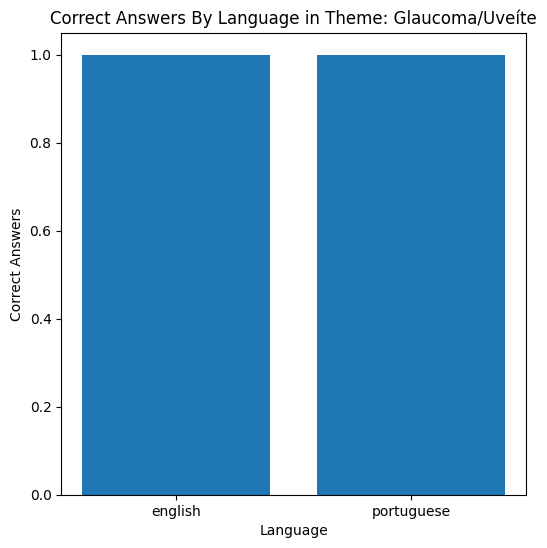

               theme  match_english  match_portuguese  Total  \
0  Lentes de Contato              1                 1      3   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 33.333333                    33.333333  


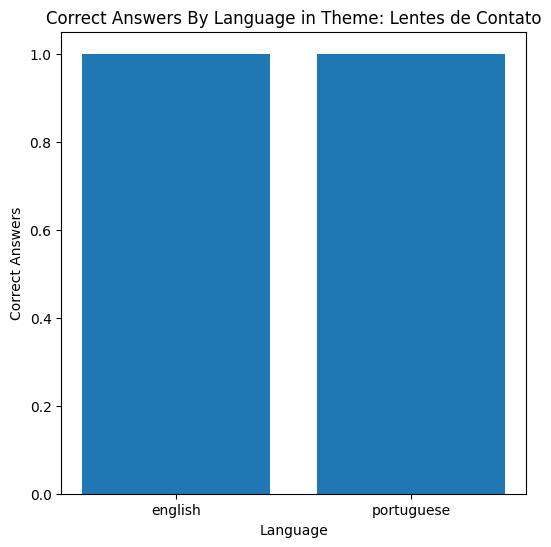

              theme  match_english  match_portuguese  Total  \
0  Neuroftalmologia              4                 6      7   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 57.142857                    85.714286  


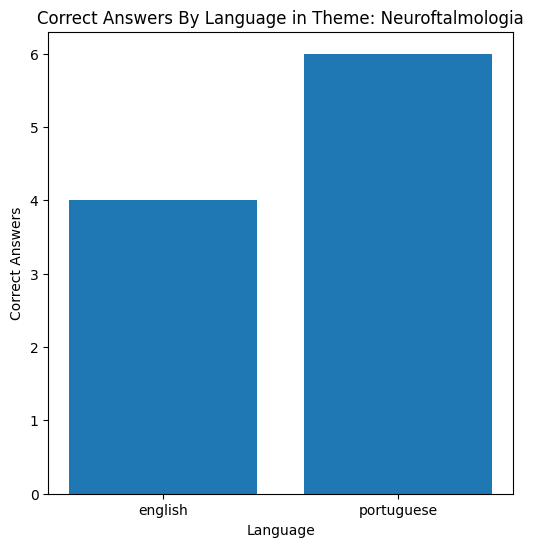

                       theme  match_english  match_portuguese  Total  \
0  Oncologia/Plástica Ocular              3                 3      3   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


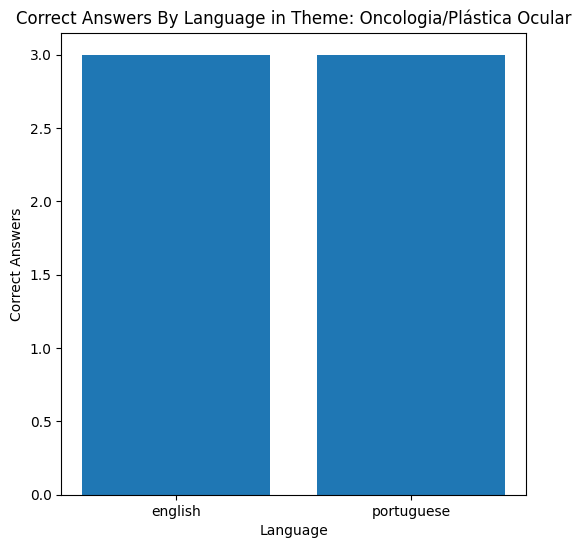

             theme  match_english  match_portuguese  Total  \
0  Plástica Ocular              9                10     16   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     56.25                         62.5  


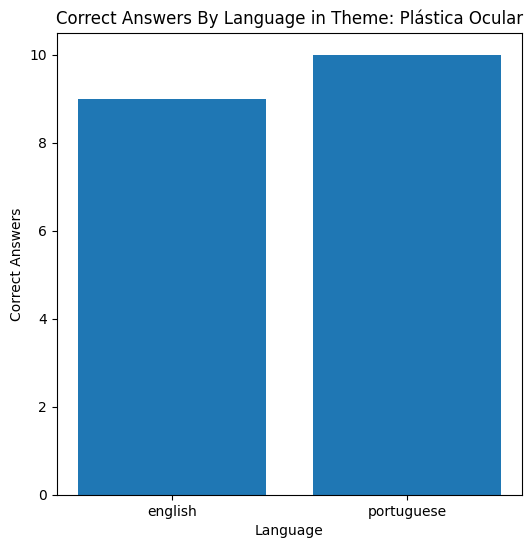

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Refração             14                12     31                  45.16129   

   portuguese_ratio_percentage  
0                    38.709677  


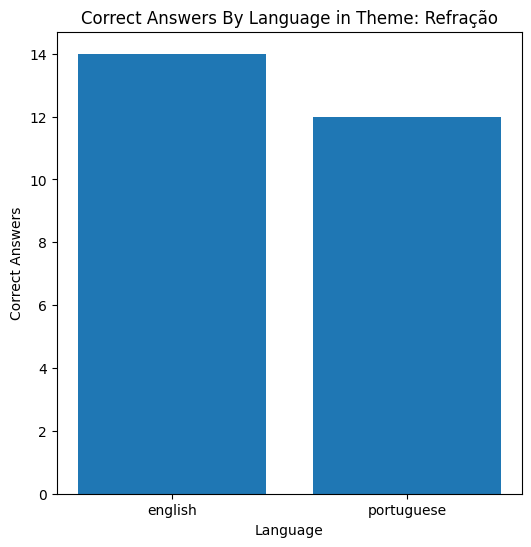

                      theme  match_english  match_portuguese  Total  \
0  Refração/Visão subnormal              1                 1      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


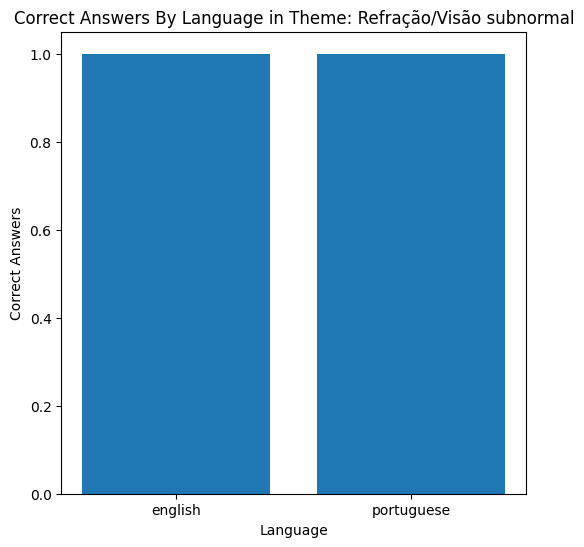

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Retina              8                10     12                 66.666667   

   portuguese_ratio_percentage  
0                    83.333333  


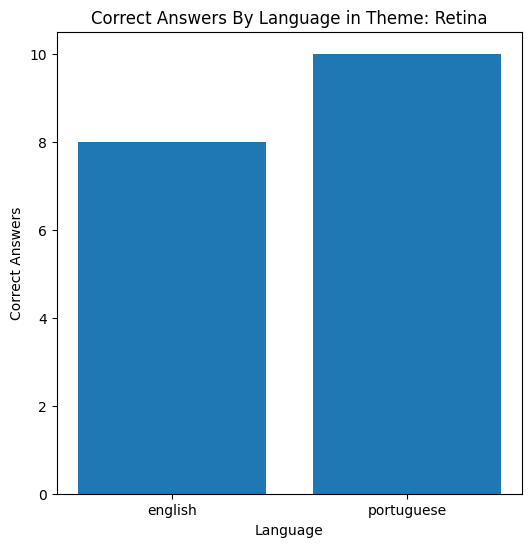

              theme  match_english  match_portuguese  Total  \
0  Retina/Oncologia              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


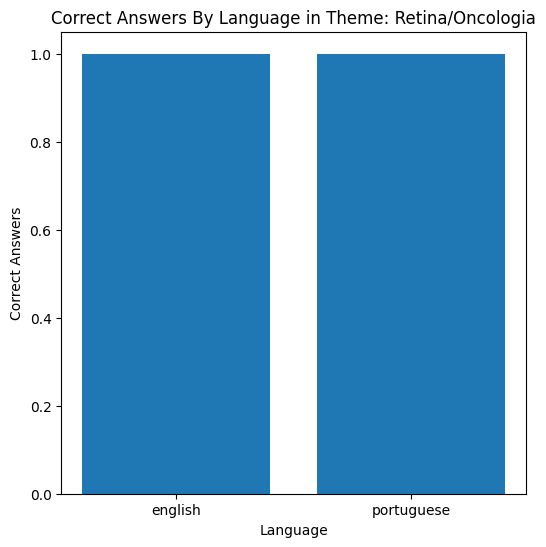

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Uveíte              4                 5      8                      50.0   

   portuguese_ratio_percentage  
0                         62.5  


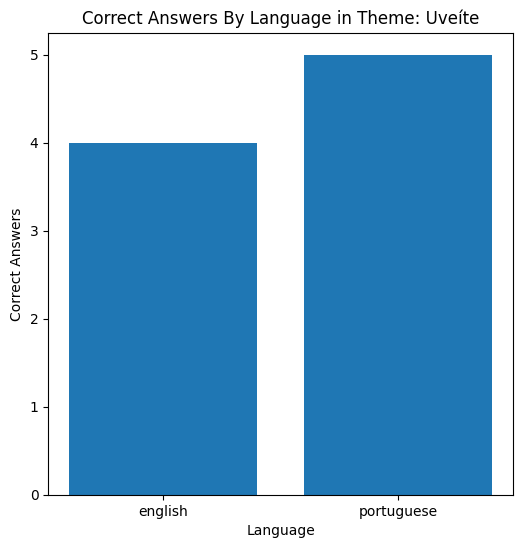

             theme  match_english  match_portuguese  Total  \
0  Visão subnormal              0                 0      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                       0.0                          0.0  


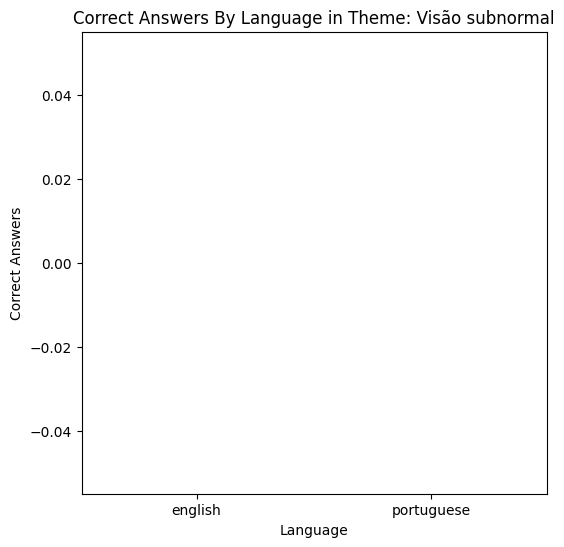

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Óptica              1                 1      1                     100.0   

   portuguese_ratio_percentage  
0                        100.0  


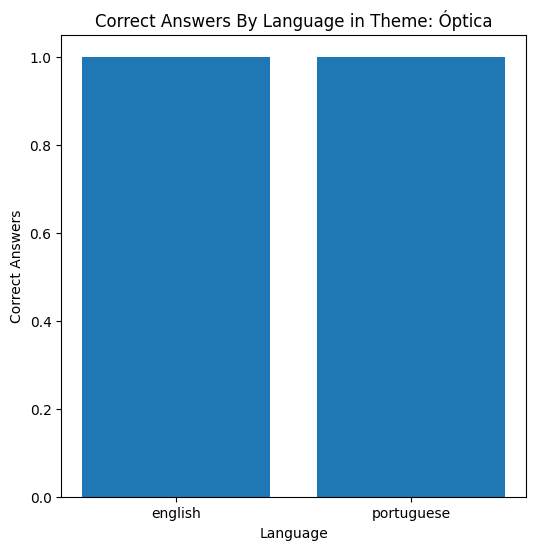

             theme  match_english  match_portuguese  Total  \
0  Óptica/Refração              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


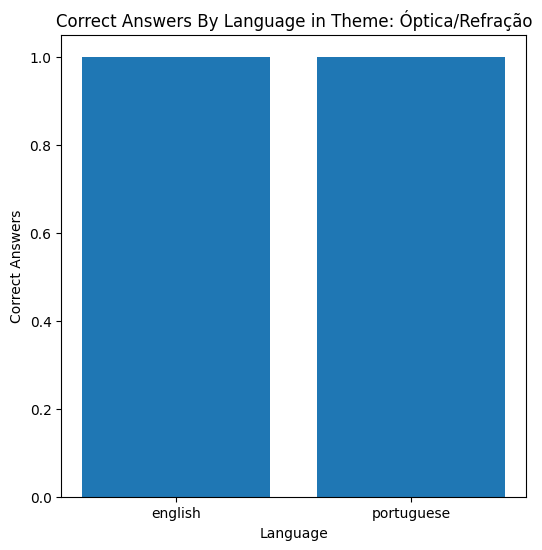

In [15]:
for theme in matches_by_test['theme']:
    df_theme = matches_by_test[matches_by_test['theme'] == theme].groupby(['theme']).agg(aggregations).reset_index()
    
    # Calculate the ratio of matches as a percentage of the total for each language
    for language in LANGUAGES:
        df_theme[f'{language}_ratio_percentage'] = (df_theme[f'match_{language}'] / df_theme['Total']) * 100
    
    print(df_theme)

    # Plot the ratio of matches for each theme
    plt.figure(figsize=(6, 6))
    totals = [df_theme[f'match_{language}'].sum() for language in LANGUAGES]
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = colors[:len(LANGUAGES)]
    
    plt.bar(LANGUAGES, totals)
    plt.xlabel('Language')
    plt.ylabel('Correct Answers')
    plt.title(f'Correct Answers By Language in Theme: {theme}')
    
    if '/' not in theme:
        plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/correct_answers_{MODEL}_{theme}.png', bbox_inches='tight')
    else:
        plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/correct_answers_{MODEL}_{theme.replace("/", "-")}.png', bbox_inches='tight')
    plt.show()